In [24]:
%matplotlib inline



Graph Convolutional Network
====================================

**Author:** `Qi Huang <https://github.com/HQ01>`_, `Minjie Wang  <https://jermainewang.github.io/>`_,
Yu Gai, Quan Gan, Zheng Zhang

<div class="alert alert-danger"><h4>Warning</h4><p>The tutorial aims at gaining insights into the paper, with code as a mean
    of explanation. The implementation thus is NOT optimized for running
    efficiency. For recommended implementation, please refer to the `official
    examples <https://github.com/dmlc/dgl/tree/master/examples>`_.</p></div>

This is a gentle introduction of using DGL to implement Graph Convolutional
Networks (Kipf & Welling et al., `Semi-Supervised Classification with Graph
Convolutional Networks <https://arxiv.org/pdf/1609.02907.pdf>`_). We explain
what is under the hood of the :class:`~dgl.nn.GraphConv` module.
The reader is expected to learn how to define a new GNN layer using DGL's
message passing APIs.


Model Overview
------------------------------------------
GCN from the perspective of message passing
```````````````````````````````````````````````
We describe a layer of graph convolutional neural network from a message
passing perspective; the math can be found `here <math_>`_.
It boils down to the following step, for each node $u$:

1) Aggregate neighbors' representations $h_{v}$ to produce an
intermediate representation $\hat{h}_u$.  2) Transform the aggregated
representation $\hat{h}_{u}$ with a linear projection followed by a
non-linearity: $h_{u} = f(W_{u} \hat{h}_u)$.

We will implement step 1 with DGL message passing, and step 2 by
PyTorch ``nn.Module``.

GCN implementation with DGL
``````````````````````````````````````````
We first define the message and reduce function as usual.  Since the
aggregation on a node $u$ only involves summing over the neighbors'
representations $h_v$, we can simply use builtin functions:



In [33]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_u(u='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

We then proceed to define the GCNLayer module. A GCNLayer essentially performs
message passing on all the nodes then applies a fully-connected layer.

<div class="alert alert-info"><h4>Note</h4><p>This is showing how to implement a GCN from scratch.  DGL provides a more
   efficient :class:`builtin GCN layer module <dgl.nn.pytorch.conv.GraphConv>`.</p></div>




In [26]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the cora dataset (the input feature size is
1433 and the number of classes is 7). The last GCN layer computes node embeddings,
so the last layer in general does not apply activation.



In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)
    
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)


We load the cora dataset using DGL's built-in data module.



In [31]:
from dgl.data import CoraGraphDataset
def load_cora_data():
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    test_mask = g.ndata['test_mask']
    return g, features, labels, train_mask, test_mask

When a model is trained, we can use the following method to evaluate
the performance of the model on the test dataset:



In [29]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

We then train the network as follows:



In [32]:
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()
# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())
optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
for epoch in range(50):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >=3:
        dur.append(time.time() - t0)
    
    acc = evaluate(net, g, features, labels, test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 0.0276 | Test Acc 0.7500 | Time(s) nan
Epoch 00001 | Loss 0.0216 | Test Acc 0.7500 | Time(s) nan
Epoch 00002 | Loss 0.0168 | Test Acc 0.7510 | Time(s) nan
Epoch 00003 | Loss 0.0131 | Test Acc 0.7510 | Time(s) 0.0130
Epoch 00004 | Loss 0.0102 | Test Acc 0.7510 | Time(s) 0.0155
Epoch 00005 | Loss 0.0080 | Test Acc 0.7470 | Time(s) 0.0147
Epoch 00006 | Loss 0.0062 | Test Acc 0.7490 | Time(s) 0.0148
Epoch 00007 | Loss 0.0049 | Test Acc 0.7470 | Time(s) 0.0144
Epoch 00008 | Loss 0.0039 | Test Acc 0.7460 | Time(s) 0.0147
Epoch 00009 | Loss 0.0031 | Test Acc 0.7470 | Time(s) 0.0144
Epoch 00010 | Loss 0.0025 | Test Acc 0.7460 | Time(s) 0.0144
Epoch 00011 | Loss 0.0020 | Test Acc 0.7450 | Time(s) 0.0142
Epoch 00012 | Loss 0.0016 | Test Acc 0.7450 | Time(s) 0.0144
Epoch 00013 | Loss 0.0014 | Test A


GCN in one formula
------------------
Mathematically, the GCN model follows this formula:

$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$

Here, $H^{(l)}$ denotes the $l^{th}$ layer in the network,
$\sigma$ is the non-linearity, and $W$ is the weight matrix for
this layer. $\tilde{D}$ and $\tilde{A}$ are separately the degree
and adjacency matrices for the graph. With the superscript ~, we are referring
to the variant where we add additional edges between each node and itself to
preserve its old representation in graph convolutions. The shape of the input
$H^{(0)}$ is $N \times D$, where $N$ is the number of nodes
and $D$ is the number of input features. We can chain up multiple
layers as such to produce a node-level representation output with shape
$N \times F$, where $F$ is the dimension of the output node
feature vector.

The equation can be efficiently implemented using sparse matrix
multiplication kernels (such as Kipf's
`pygcn <https://github.com/tkipf/pygcn>`_ code). The above DGL implementation
in fact has already used this trick due to the use of builtin functions.

Note that the tutorial code implements a simplified version of GCN where we
replace $\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$ with
$\tilde{A}$. For a full implementation, see our example
`here  <https://github.com/dmlc/dgl/tree/master/examples/pytorch/gcn>`_.





In [3]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
from dgl.data import citation_graph as citegrh

data = citegrh.load_cora()

G = dgl.DGLGraph(data.graph)
labels = th.tensor(data.labels)

# find all the nodes labeled with class 0
label0_nodes = th.nonzero(labels == 0).squeeze()
# find all the edges pointing to class 0 nodes
src, _ = G.in_edges(label0_nodes)
src_labels = labels[src]
# find all the edges whose both endpoints are in class 0
intra_src = th.nonzero(src_labels == 0)
print('Intra-class edges percent: %.4f' % (len(intra_src) / len(src_labels)))


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Intra-class edges percent: 0.6994


C:\Users\benno\anaconda3\envs\gpu\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.graph will be deprecated, please use dataset[0] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\benno\anaconda3\envs\gpu\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
C:\Users\benno\anaconda3\envs\gpu\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.label will be deprecated, please use g.ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


C:\Users\benno\anaconda3\envs\gpu\lib\site-packages\dgl\base.py:45: DGLWarning: DGLGraph.__len__ is deprecated.Please directly call DGLGraph.number_of_nodes.
  return warnings.warn(message, category=category, stacklevel=1)


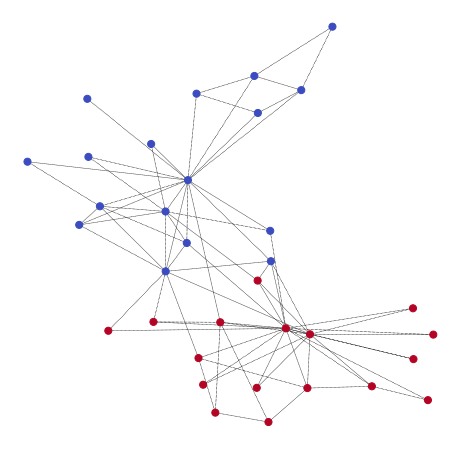

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import dgl
from dgl.data import KarateClubDataset
#train_set = dgl.data.CoraBinary()
train_set=KarateClubDataset()
G1 = train_set[0]
label1 = G1.ndata['label']
#G1, pmpd1, label1 = train_set[1]
nx_G1 = G1.to_networkx()

def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'),
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)
visualize(label1, nx_G1)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))


In [ ]:
# Create input
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [ ]:
#loss function for unsupervised task
class CrossEntropyLoss(nn.Module):
    def forward(self, block_outputs, pos_graph, neg_graph):
        with pos_graph.local_scope():
            pos_graph.ndata['h'] = block_outputs
            pos_graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            pos_score = pos_graph.edata['score']
        with neg_graph.local_scope():
            neg_graph.ndata['h'] = block_outputs
            neg_graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            neg_score = neg_graph.edata['score']

        score = torch.cat([pos_score, neg_score])
        label = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).long()
        loss = F.binary_cross_entropy_with_logits(score, label.float())
        return loss


In [17]:
from dgl.data import CoraGraphDataset
dataset = CoraGraphDataset()
g=dataset[0]
g.ndata['test_mask']
data =KarateClubDataset()
n_classes = data.num_classes
g = data[0]
print(n_classes,len(g))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
2 34


C:\Users\benno\anaconda3\envs\gpu\lib\site-packages\dgl\base.py:45: DGLWarning: DGLGraph.__len__ is deprecated.Please directly call DGLGraph.number_of_nodes.
  return warnings.warn(message, category=category, stacklevel=1)
